## **1. Install & Import Required Libraries**

In [35]:
#!pip install yfinance nltk transformers tensorflow scikit-learn pandas matplotlib seaborn

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Dropout, Bidirectional, LSTM, Concatenate
from keras.regularizers import L1L2
from keras.optimizers import Adam
import nltk
import joblib
from nltk.sentiment import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

## **2. Load & Preprocess Data**

In [2]:
# Load dataset
data = pd.read_csv("/content/sample_data/Data/merged (1).csv")  # Upload your file to Colab first
data["date"] = pd.to_datetime(data["Date"])
data.set_index("date", inplace=True)
#data = data.drop(["volume"], axis=1)
# Clean data - convert strings to float (if needed)
for col in ['Open', 'High', 'Low', 'Close']:
    if col in data.columns and isinstance(data[col].iloc[0], str):
        data[col] = data[col].str.replace(',', '').astype(float)

# Display sample
print("\nData Sample:")
print(data.head())


Data Sample:
                  Date  Open  High   Low  Close          Sector
date                                                           
1979-01-02  1979-01-02  14.7  14.7  14.7   14.7  Gold price INR
1979-01-03  1979-01-03  14.7  14.7  14.7   14.7  Gold price INR
1979-01-04  1979-01-04  14.8  14.8  14.8   14.8  Gold price INR
1979-01-05  1979-01-05  15.1  15.1  15.1   15.1  Gold price INR
1979-01-08  1979-01-08  15.1  15.1  15.1   15.1  Gold price INR


## **3. Feature Engineering (TECH+ Component)**

In [3]:
def add_technical_indicators(df):
    # Moving Averages
    df['SMA_10'] = df['Close'].rolling(window=10).mean()
    df['EMA_10'] = df['Close'].ewm(span=10, adjust=False).mean()

    # RSI Calculation
    delta = df['Close'].diff()
    gain = delta.clip(lower=0)
    loss = -delta.clip(upper=0)
    avg_gain = gain.rolling(14).mean()
    avg_loss = loss.rolling(14).mean()
    rs = avg_gain / avg_loss
    df['RSI'] = 100 - (100 / (1 + rs))

    # ATR Calculation
    high_low = df['High'] - df['Low']
    high_close = np.abs(df['High'] - df['Close'].shift())
    low_close = np.abs(df['Low'] - df['Close'].shift())
    true_range = pd.concat([high_low, high_close, low_close], axis=1).max(axis=1)
    df['ATR'] = true_range.rolling(14).mean()

    return df

# Add technical indicators
data = add_technical_indicators(data)
data = data.dropna()
print(data.head())

                  Date  Open  High   Low  Close          Sector  SMA_10  \
date                                                                      
1979-01-22  1979-01-22  15.4  15.4  15.4   15.4  Gold price INR   15.00   
1979-01-23  1979-01-23  15.5  15.5  15.5   15.5  Gold price INR   15.06   
1979-01-24  1979-01-24  15.8  15.8  15.8   15.8  Gold price INR   15.16   
1979-01-25  1979-01-25  15.8  15.8  15.8   15.8  Gold price INR   15.26   
1979-01-26  1979-01-26  15.8  15.8  15.8   15.8  Gold price INR   15.38   

               EMA_10        RSI       ATR  
date                                        
1979-01-22  15.127855  62.962963  0.192857  
1979-01-23  15.195518  64.285714  0.200000  
1979-01-24  15.305424  66.666667  0.214286  
1979-01-25  15.395347  62.962963  0.192857  
1979-01-26  15.468920  62.962963  0.192857  


## **5. Prepare Data for BiLSTM**

In [4]:
# Prepare features and target
target = data[['Close']]
# Select only numeric columns
numeric_cols = data.select_dtypes(include=['float64', 'int64']).columns
features = data[numeric_cols].drop(['Close'], axis=1)

print("\nFeatures being used:")
print(features.head())

# Scale data
feature_scaler = MinMaxScaler()
target_scaler = MinMaxScaler()

scaled_features = feature_scaler.fit_transform(features)
scaled_target = target_scaler.fit_transform(target)

print("\nScaled features shape:", scaled_features.shape)
print("Scaled target shape:", scaled_target.shape)
seq_cols = 5  # Number of columns for sequence data (e.g., OHLCV)

features_seq = scaled_features[:, :seq_cols]
features_tech = scaled_features[:, seq_cols:]



Features being used:
            Open  High   Low  SMA_10     EMA_10        RSI       ATR
date                                                                
1979-01-22  15.4  15.4  15.4   15.00  15.127855  62.962963  0.192857
1979-01-23  15.5  15.5  15.5   15.06  15.195518  64.285714  0.200000
1979-01-24  15.8  15.8  15.8   15.16  15.305424  66.666667  0.214286
1979-01-25  15.8  15.8  15.8   15.26  15.395347  62.962963  0.192857
1979-01-26  15.8  15.8  15.8   15.38  15.468920  62.962963  0.192857

Scaled features shape: (105356, 7)
Scaled target shape: (105356, 1)


## **6. Create Sequences**

In [5]:
def create_sequences_dual(seq_data, tech_data, target, seq_length=30):
    X_seq, X_tech, y = [], [], []
    for i in range(seq_length, len(seq_data)):
        X_seq.append(seq_data[i-seq_length:i, :])         # 3D input
        X_tech.append(tech_data[i, :])                     # 2D input (only current timestep)
        y.append(target[i, 0])                             # 1D target
    return np.array(X_seq), np.array(X_tech), np.array(y)

X_seq, X_tech, y = create_sequences_dual(features_seq, features_tech, scaled_target)

# Train-test split
train_size = int(0.8 * len(X_seq))

X_train_seq, X_test_seq = X_seq[:train_size], X_seq[train_size:]
X_train_tech, X_test_tech = X_tech[:train_size], X_tech[train_size:]
y_train, y_test = y[:train_size], y[train_size:]


## **7. Build Hybrid BiLSTM Model**

In [7]:


def build_bilstm_with_tech(input_shape_seq, input_shape_tech, fine_tune=False):
    # === Sequence input (time series prices, etc.)
    seq_input = Input(shape=input_shape_seq, name='sequence_input')
    x = Bidirectional(LSTM(128, return_sequences=True,
                           kernel_regularizer=L1L2(l1=0.01, l2=0.01)),
                      name="bi_lstm_1")(seq_input)
    x = Dropout(0.4)(x)
    x = Bidirectional(LSTM(64), name="bi_lstm_2")(x)
    x = Dropout(0.3)(x)

    # === Technical indicators input (Tech+ features)
    tech_input = Input(shape=input_shape_tech, name='tech_input')
    y = Dense(32, activation='relu')(tech_input)

    # === Combine sequence features and technical indicators
    combined = Concatenate()([x, y])

    # === Fully connected layers
    combined = Dense(64, activation='relu')(combined)
    combined = Dropout(0.3)(combined)
    output = Dense(1, name='output')(combined)

    # === Build model
    model = Model(inputs=[seq_input, tech_input], outputs=output)

    # === Fine-tuning logic
    if fine_tune:
        # Freeze first BiLSTM layer
        model.get_layer('bi_lstm_1').trainable = False

    # Compile
    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='mse',
                  metrics=['mae'])

    return model

model = build_bilstm_with_tech(
    input_shape_seq=(X_train_seq.shape[1], X_train_seq.shape[2]),
    input_shape_tech=(X_train_tech.shape[1],),
    fine_tune=False
)

model.summary()



Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ sequence_input      │ (None, 30, 5)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bi_lstm_1           │ (None, 30, 256)   │    137,216 │ sequence_input[0… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 30, 256)   │          0 │ bi_lstm_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bi_lstm_2           │ (None, 128)       │    164,352 │ dropout[0][0]     │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ tech_input          │ (None, 2)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 128)       │          0 │ bi_lstm_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 32)        │         96 │ tech_input[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 160)       │          0 │ dropout_1[0][0],  │
│ (Concatenate)       │                   │            │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 64)        │     10,304 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 64)        │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output (Dense)      │ (None, 1)         │         65 │ dropout_2[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 312,033 (1.19 MB)

 Trainable params: 312,033 (1.19 MB)

 Non-trainable params: 0 (0.00 B)

## **8. Train the Model**

Epoch 1/50
2634/2634 ━━━━━━━━━━━━━━━━━━━━ 539s 201ms/step - loss: 0.2163 - mae: 0.0275 - val_loss: 0.0104 - val_mae: 0.0474
Epoch 2/50
2634/2634 ━━━━━━━━━━━━━━━━━━━━ 557s 199ms/step - loss: 0.0072 - mae: 0.0203 - val_loss: 0.0111 - val_mae: 0.0486
Epoch 3/50
2634/2634 ━━━━━━━━━━━━━━━━━━━━ 565s 200ms/step - loss: 0.0071 - mae: 0.0199 - val_loss: 0.0115 - val_mae: 0.0505
Epoch 4/50
2634/2634 ━━━━━━━━━━━━━━━━━━━━ 557s 198ms/step - loss: 0.0071 - mae: 0.0193 - val_loss: 0.0110 - val_mae: 0.0477
Epoch 5/50
2634/2634 ━━━━━━━━━━━━━━━━━━━━ 526s 200ms/step - loss: 0.0071 - mae: 0.0190 - val_loss: 0.0114 - val_mae: 0.0495
Epoch 6/50
2634/2634 ━━━━━━━━━━━━━━━━━━━━ 561s 200ms/step - loss: 0.0071 - mae: 0.0189 - val_loss: 0.0111 - val_mae: 0.0475
Epoch 7/50
2634/2634 ━━━━━━━━━━━━━━━━━━━━ 565s 201ms/step - loss: 0.0071 - mae: 0.0189 - val_loss: 0.0111 - val_mae: 0.0458
Epoch 8/50
2634/2634 ━━━━━━━━━━━━━━━━━━━━ 558s 199ms/step - loss: 0.0072 - mae: 0.0190 - val_loss: 0.0108 - val_mae: 0.0475
Epoch 9/

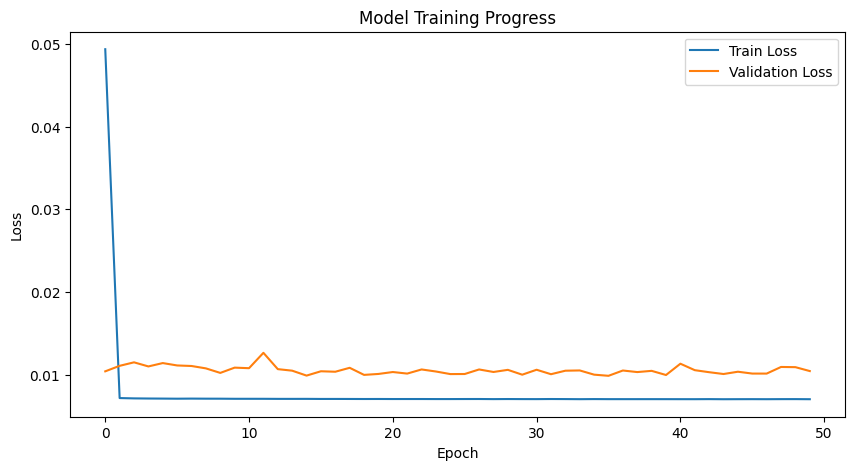

In [8]:
history = model.fit(
    [X_train_seq, X_train_tech],  # 👈 pass as list
    y_train,
    epochs=50,
    batch_size=32,
    validation_data=([X_test_seq, X_test_tech], y_test),
    verbose=1
)

# Plot training history
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Training Progress')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

## **9. Evaluate Model Performance**

In [9]:
def evaluate_model(actual, predicted):
    metrics = {
        'MSE': mean_squared_error(actual, predicted),
        'RMSE': np.sqrt(mean_squared_error(actual, predicted)),
        'MAE': mean_absolute_error(actual, predicted),
        'R2 Score': r2_score(actual, predicted)
    }
    return metrics

# === Make predictions ===
# Scaled predictions
train_pred_scaled = model.predict([X_train_seq, X_train_tech])
test_pred_scaled = model.predict([X_test_seq, X_test_tech])

# Inverse transform predictions
train_pred = target_scaler.inverse_transform(train_pred_scaled.reshape(-1, 1))
test_pred = target_scaler.inverse_transform(test_pred_scaled.reshape(-1, 1))

# Inverse transform true targets
y_train_original = target_scaler.inverse_transform(y_train.reshape(-1, 1))
y_test_original = target_scaler.inverse_transform(y_test.reshape(-1, 1))

# Optionally also for direct use
y_pred_scaled = model.predict([X_test_seq, X_test_tech])
y_pred = target_scaler.inverse_transform(y_pred_scaled.reshape(-1, 1))
y_true = target_scaler.inverse_transform(y_test.reshape(-1, 1))

# Evaluate model performance
train_metrics = evaluate_model(y_train_original, train_pred)
test_metrics = evaluate_model(y_test_original, test_pred)


print("\nTraining Metrics:")
print(pd.DataFrame([train_metrics]))

print("\nTest Metrics:")
print(pd.DataFrame([test_metrics]))

2634/2634 ━━━━━━━━━━━━━━━━━━━━ 126s 47ms/step
659/659 ━━━━━━━━━━━━━━━━━━━━ 28s 42ms/step
659/659 ━━━━━━━━━━━━━━━━━━━━ 28s 42ms/step

Training Metrics:
            MSE         RMSE          MAE  R2 Score
0  5.896906e+06  2428.354531  1610.610574  0.808823

Test Metrics:
            MSE         RMSE          MAE  R2 Score
0  3.841090e+07  6197.653102  4371.595016  0.667391


## **10. Visualize Predictions**

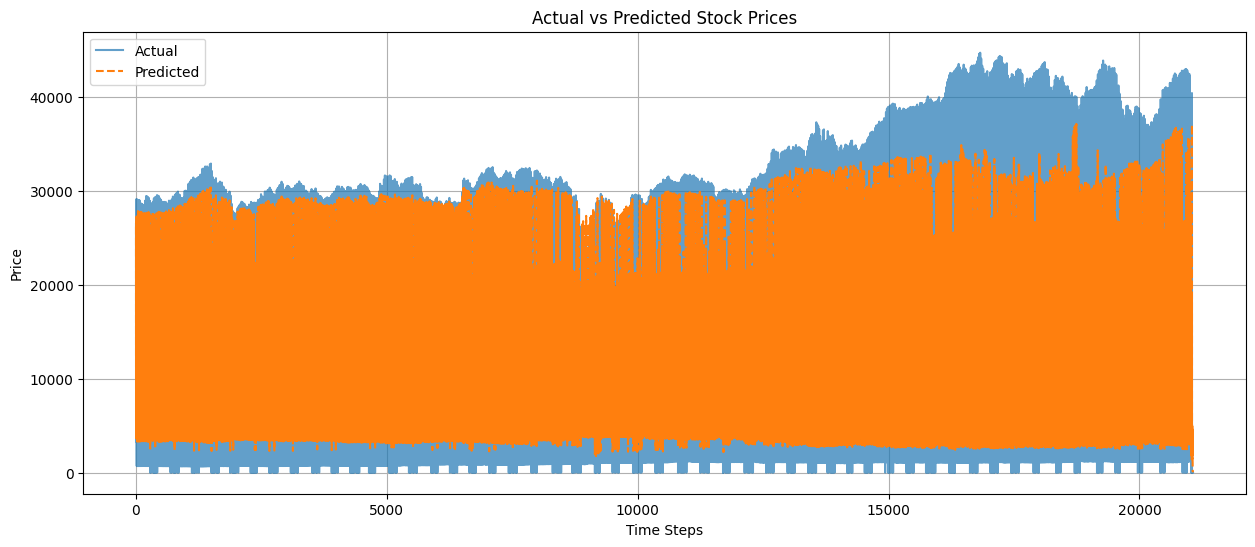

In [10]:
plt.figure(figsize=(15, 6))
plt.plot(target_scaler.inverse_transform(y_test.reshape(-1, 1)), label='Actual', alpha=0.7)
plt.plot(test_pred, label='Predicted', linestyle='--')
plt.title('Actual vs Predicted Stock Prices')
plt.xlabel('Time Steps')
plt.ylabel('Price')
plt.legend()
plt.grid()
plt.show()

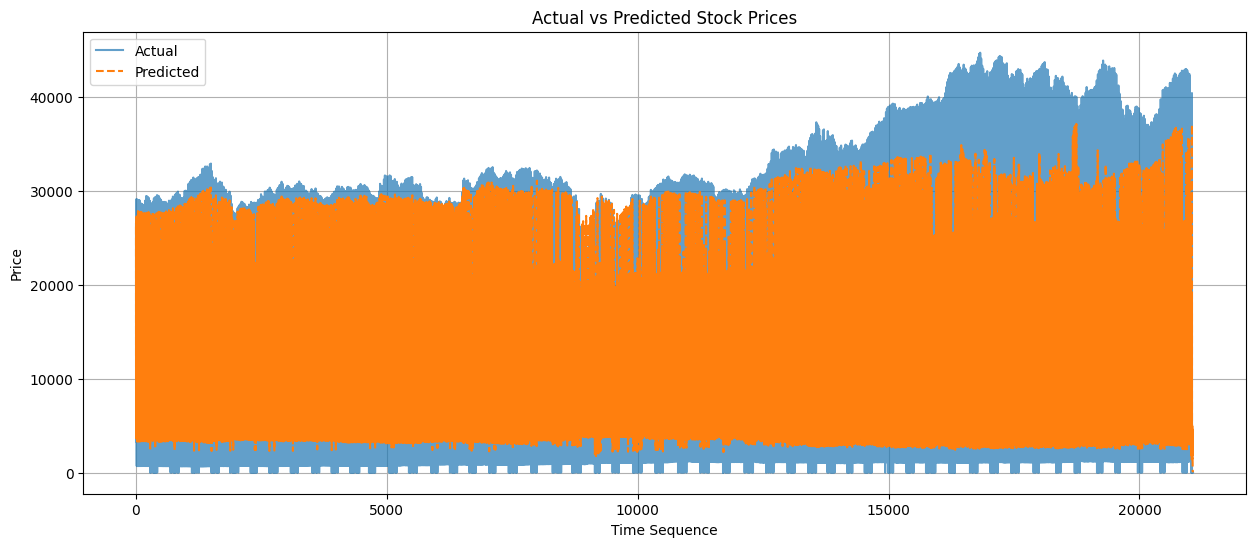

In [11]:
# Create sequential index if date index is not available
plt.figure(figsize=(15, 6))
plt.plot(range(len(y_test)), target_scaler.inverse_transform(y_test.reshape(-1, 1)),
         label='Actual', alpha=0.7)
plt.plot(range(len(test_pred)), test_pred,
         label='Predicted', linestyle='--')

plt.title('Actual vs Predicted Stock Prices')
plt.xlabel('Time Sequence')
plt.ylabel('Price')
plt.legend()
plt.grid()
plt.show()

## **11. Future Price Prediction**

In [24]:
def predict_next_day_with_signal(model, last_seq, last_tech):
    """
    Predict the next day's price and return BUY/SELL signal
    """
    # Predict next day's scaled price
    next_pred_scaled = model.predict([last_seq.reshape(1, *last_seq.shape),
                                      last_tech.reshape(1, *last_tech.shape)])[0][0]

    # Inverse scale prediction
    next_pred = target_scaler.inverse_transform([[next_pred_scaled]])[0][0]

    # Get last actual price
    last_close_scaled = last_seq[-1, -1]  # Assuming last column is scaled close price
    last_close = target_scaler.inverse_transform([[last_close_scaled]])[0][0]

    # Determine signal
    signal = "BUY" if next_pred > last_close else "SELL"

    return next_pred, signal


In [25]:
# Get last sequence and technical indicators
last_seq = X_test_seq[-1]   # Shape: (timesteps, features)
last_tech = X_test_tech[-1] # Shape: (tech_features,)

# Predict
next_price, signal = predict_next_day_with_signal(model, last_seq, last_tech)

print(f"Predicted Price for Next Day: {next_price:.2f}")
print(f"Suggested Action: {signal}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
Predicted Price for Next Day: 213.29
Suggested Action: SELL


In [34]:

# Load model and scaler
model.save("/content/sample_data/bilstm_with_tech.h5")
# joblib.load("/content/sample_data/target_scaler.pkl")

print("Model and scaler loaded successfully.")


Model and scaler loaded successfully.
